In [1]:
!pip install datasets==3.0.0

In [2]:
import pandas as pd
from datasets import load_dataset
import datasets
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from wordcloud import WordCloud
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import unittest
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Download the dataset

In [3]:
data = load_dataset("tyqiangz/multilingual-sentiments", "german")


In [4]:
df_train = data["train"].to_pandas()
df_test = data["test"].to_pandas()
df_val = data["validation"].to_pandas()

# Exploratory data analysis

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1839 non-null   object
 1   source  1839 non-null   object
 2   label   1839 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 43.2+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    870 non-null    object
 1   source  870 non-null    object
 2   label   870 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 20.5+ KB


In [7]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    324 non-null    object
 1   source  324 non-null    object
 2   label   324 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 7.7+ KB


In [8]:
df_train.head()

,text,source,label
0,Normal bin ich ja ned der mensch dwer sich bes...,sb_10k,2
1,VfB Stuttgart gegen SV Hamburg: Das Warten auf...,sb_10k,1
2,@user @user @user @user @user @user @user @use...,sb_10k,0
3,@user glaub ich! XD 30€ sind echt not bad T___...,sb_10k,2
4,@user. Diviertete,sb_10k,1


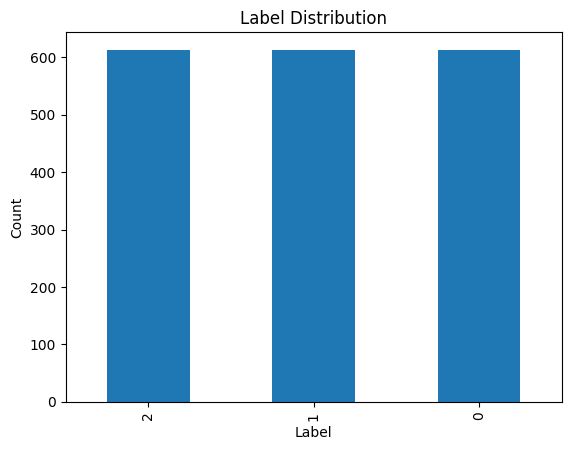

In [9]:
df_train["label"].value_counts().plot(kind="bar")
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

(-0.5, 799.5, 399.5, -0.5)

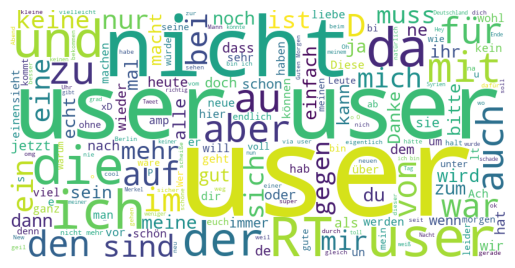

In [10]:
wc = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df_train["text"]))
plt.imshow(wc)
plt.axis('off')

# Data preprocessing

### Cleaning the text

In [11]:
def clean_text(text):
  #Lowercasing
  text = text.lower()
  #Removing @user
  text = re.sub(r'@\w+', '', text)
  #Removing numbers
  text = re.sub(r'\d+', '', text)
  #Removing extra whitespace
  text = re.sub(r'\s+', ' ', text).strip()

  return text

In [12]:
df_train['cleaned'] = df_train['text'].apply(clean_text)

In [13]:
df_test['cleaned'] = df_test['text'].apply(clean_text)

In [14]:
df_val['cleaned'] = df_val['text'].apply(clean_text)

### TF-IDF

In [15]:
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")

german_stopwords = stopwords.words("german")

vectorizer = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1,2),
    stop_words=german_stopwords,
    strip_accents=None,
    token_pattern=r"(?u)\b\w+\b"
    )

X_train_vec = vectorizer.fit_transform(df_train['cleaned']).toarray()
X_test_vec = vectorizer.transform(df_test['cleaned']).toarray()
X_val_vec = vectorizer.transform(df_val['cleaned']).toarray()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


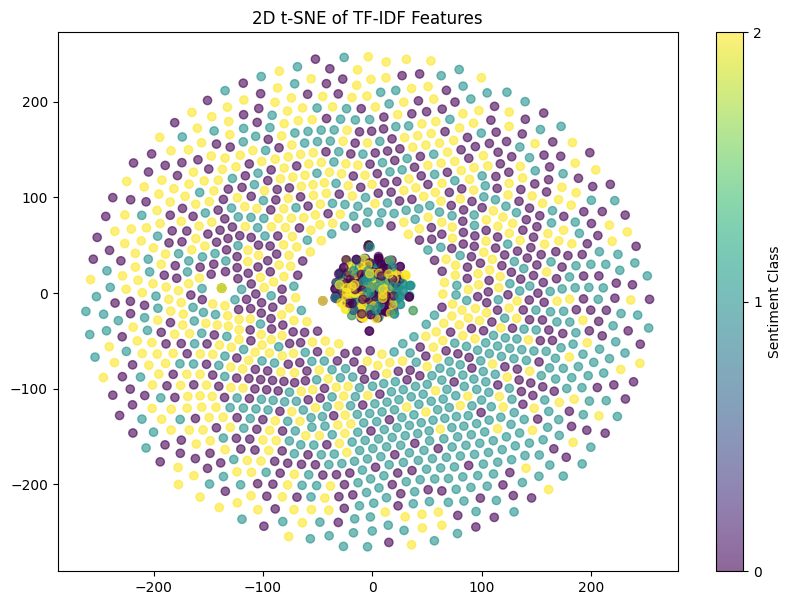

In [16]:
tsne = TSNE(n_components=2, perplexity=40, learning_rate=200)
X_train_2d = tsne.fit_transform(X_train_vec)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    X_train_2d[:, 0],
    X_train_2d[:, 1],
    c = df_train['label'],
    cmap="viridis",
    alpha=0.6
)

plt.colorbar(scatter, ticks=[0,1,2], label="Sentiment Class")
plt.title("2D t-SNE of TF-IDF Features")
plt.show()

(-0.5, 799.5, 399.5, -0.5)

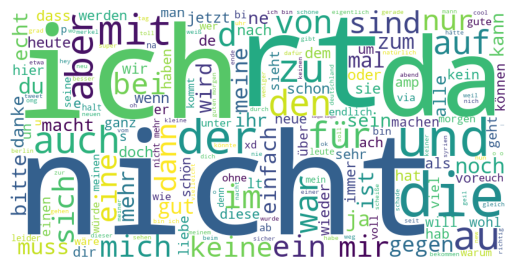

In [17]:
wc = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df_train["cleaned"]))
plt.imshow(wc)
plt.axis('off')

### UnitTests

In [24]:
class TestDataPipeline(unittest.TestCase):
    def test_1_clean_text_functionality(self):
        """Test clean_text for lowercasing, @user, numbers, and extra whitespace."""
        test_string = "Hello @user123 this is a TEST 123 with   extra spaces.!"
        expected_string = "hello this is a test with extra spaces.!"
        self.assertEqual(clean_text(test_string), expected_string)

    def test_2_dataframe_loading_and_columns(self):
        """Test if dataframes are loaded and have 'text' and 'label' columns."""
        self.assertIsInstance(df_train, pd.DataFrame)
        self.assertIsInstance(df_test, pd.DataFrame)
        self.assertIsInstance(df_val, pd.DataFrame)

        self.assertIn('text', df_train.columns)
        self.assertIn('label', df_train.columns)
        self.assertIn('text', df_test.columns)
        self.assertIn('label', df_test.columns)
        self.assertIn('text', df_val.columns)
        self.assertIn('label', df_val.columns)

    def test_3_tfidf_vectorizer_output_shape(self):
        """Test if TF-IDF vectorized arrays have the correct shape."""
        self.assertEqual(X_train_vec.shape[0], len(df_train))
        self.assertEqual(X_test_vec.shape[0], len(df_test))
        self.assertEqual(X_val_vec.shape[0], len(df_val))

        self.assertEqual(X_train_vec.shape[1], 3000)
        self.assertEqual(X_test_vec.shape[1], 3000)
        self.assertEqual(X_val_vec.shape[1], 3000)

    def test_4_tfidf_vectorizer_stopwords_and_ngrams(self):
        """Test TF-IDF vectorizer for stop word removal and n-gram inclusion on a sample."""
        sample_text = ["ein guter test", "dies ist ein weiterer test"] # 'ein', 'ist' are stopwords
        temp_vectorizer = TfidfVectorizer(
            max_features=3000,
            ngram_range=(1,2),
            stop_words=german_stopwords,
            strip_accents=None,
            token_pattern=r"(?u)\b\w+\b"
        )
        temp_vec = temp_vectorizer.fit_transform(sample_text).toarray()
        feature_names = temp_vectorizer.get_feature_names_out()

        self.assertNotIn('ein', feature_names)
        self.assertNotIn('ist', feature_names)
        self.assertIn('guter test', feature_names)
        self.assertIn('weiterer test', feature_names)
        self.assertIn('test', feature_names)

    def test_5_cleaned_text_column_exists(self):
        """Test if the 'cleaned' column exists in all dataframes after cleaning."""
        self.assertIn('cleaned', df_train.columns)
        self.assertIn('cleaned', df_test.columns)
        self.assertIn('cleaned', df_val.columns)
        self.assertTrue(len(df_train['cleaned'].iloc[0]) > 0)


# To run the tests
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.005s

OK


# Model training

### Baseline Model — TF-IDF + Neural Network

In [25]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(3, activation='softmax', input_shape=(X_train_vec.shape[1],))
])

# Compile the model
model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

# Train the model
model.fit(X_train_vec, df_train['label'].values, epochs=20, batch_size=50, validation_data=(X_val_vec, df_val['label'].values))


Epoch 1/20
37/37 [==============================] - 1s 9ms/step - loss: 1.0965 - accuracy: 0.3665 - val_loss: 1.0923 - val_accuracy: 0.4444
Epoch 2/20
37/37 [==============================] - 0s 4ms/step - loss: 1.0827 - accuracy: 0.5862 - val_loss: 1.0871 - val_accuracy: 0.5031
Epoch 3/20
37/37 [==============================] - 0s 4ms/step - loss: 1.0691 - accuracy: 0.7134 - val_loss: 1.0819 - val_accuracy: 0.5309
Epoch 4/20
37/37 [==============================] - 0s 4ms/step - loss: 1.0558 - accuracy: 0.7787 - val_loss: 1.0767 - val_accuracy: 0.5432
Epoch 5/20
37/37 [==============================] - 0s 4ms/step - loss: 1.0427 - accuracy: 0.8080 - val_loss: 1.0719 - val_accuracy: 0.5556
Epoch 6/20
37/37 [==============================] - 0s 3ms/step - loss: 1.0296 - accuracy: 0.8369 - val_loss: 1.0674 - val_accuracy: 0.5494
Epoch 7/20
37/37 [==============================] - 0s 3ms/step - loss: 1.0169 - accuracy: 0.8483 - val_loss: 1.0626 - val_accuracy: 0.5525
Epoch 8/20
37/37 [==

### Advanced Model — Multilingual Transformer Fine-Tuning (XLM-RoBERTa)

In [30]:
model_name = "xlm-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

In [32]:
from sklearn.metrics import accuracy_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

In [34]:
tokenized = data.map(tokenize_function, batched=True)

tokenized = tokenized.remove_columns(["text"])
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format("torch")

Map:   0%|          | 0/1839 [00:00<?, ? examples/s]

Map:   0%|          | 0/324 [00:00<?, ? examples/s]

Map:   0%|          | 0/870 [00:00<?, ? examples/s]

In [ ]:

# Training arguments (Transformers v5)
training_args = TrainingArguments(
    output_dir="xlmroberta_german_output",
    eval_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    load_best_model_at_end=True,
    save_strategy="epoch",
    weight_decay=0.01,
    warmup_ratio=0.1,
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

Epoch,Training Loss,Validation Loss


In [ ]:
save_path = "models/german"

trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

### Visualization

In [ ]:
logs = trainer.state.log_history

epochs = []
train_loss = []
val_loss = []
val_acc = []

for log in logs:
    if "epoch" in log:
        epoch = log["epoch"]
        if epoch not in epochs:
            epochs.append(epoch)
    if "loss" in log:
        train_loss.append(log["loss"])
    if "eval_loss" in log:
        val_loss.append(log["eval_loss"])
    if "eval_accuracy" in log:
        val_acc.append(log["eval_accuracy"])

#Loss
plt.figure(figsize=(10,4))
plt.plot(range(1, int(training_args.num_train_epochs)+1), train_loss, label="Training Loss", marker='o')
plt.plot(range(1, int(training_args.num_train_epochs)+1), val_loss, label="Validation Loss", marker='o')
plt.title("Training and Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

#Accuracy
if val_acc:
    plt.figure(figsize=(10,4))
    plt.plot(range(1, int(training_args.num_train_epochs)+1), val_acc, label="Validation Accuracy", marker='o', color='green')
    plt.title("Validation Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

### Evaluation on test data

In [ ]:
test_dataset = tokenized["test"]

test_metrics = trainer.evaluate(test_dataset)
print(test_metrics)

### Confusion matrix

In [ ]:
pred_output = trainer.predict(tokenized["test"])
y_pred = pred_output.predictions.argmax(axis=1)
y_true = tokenized["test"]["labels"]

In [ ]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – RoBERTa-base")
plt.show()